In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

In this Jupyter notebook I go over a simple example of fitting a simple model - a straight line, through a few data points with known Gaussian error bars. 

The following is largely based on the paper by Hogg, Bovy & Lang (2010), available on the arxiv: https://arxiv.org/abs/1008.4686.

# Data

We start by generating some fake data points from a linear line model with Gaussian noise, this way we can
check if our inference method of choice recovers the "true" values of the model parameters.

(0, 2.0)

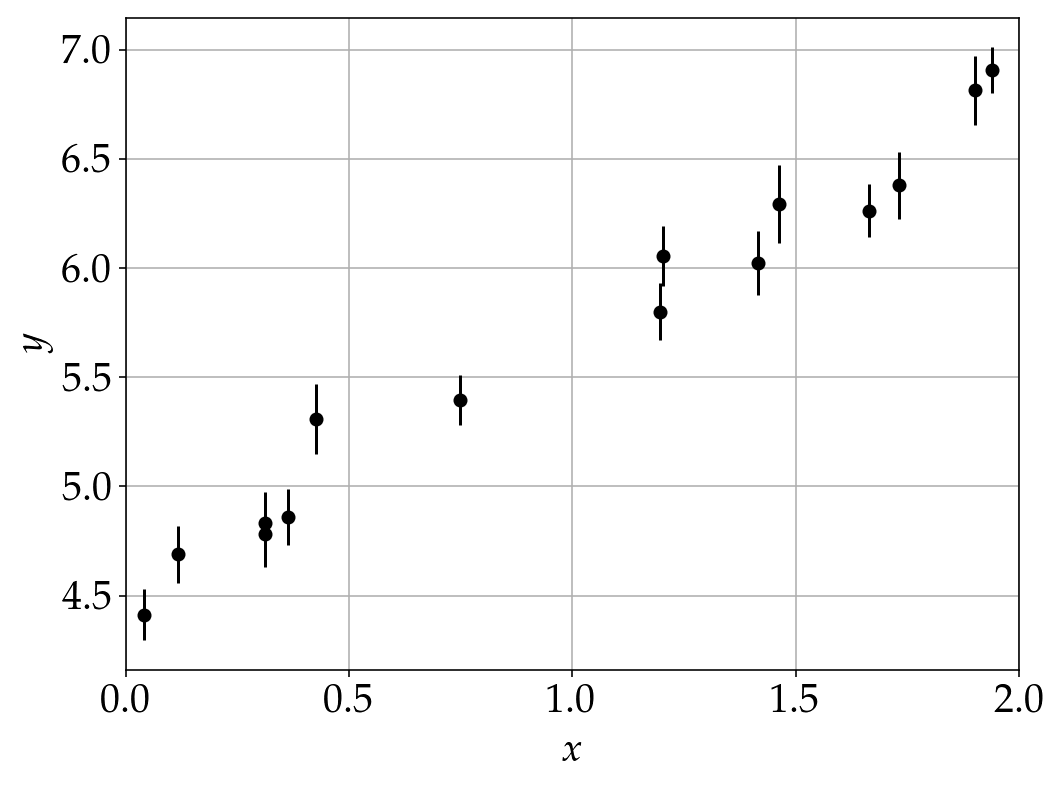

In [2]:
n_data = 15 # number of data points
m_true = 1.2 # randomly chosen truth
b_true = 4.5 

np.random.seed(42) # for reproducibility

# randomly generate some x values over some domain by sampling from a uniform distribution
x = np.random.uniform(0, 2., n_data)
x.sort() # sort the values in place

# evaluate the true model at the given x values
y = m_true*x + b_true

# Heteroscedastic Gaussian uncertainties only in y direction
y_err = np.random.uniform(0.1, 0.2, size=n_data) # randomly generate uncertainty for each point
y = np.random.normal(y, y_err) # re-sample y data with noise

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(x, y, y_err, fmt='o', color='black')
ax.grid(True)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim(0, 2.)
# ax.set_ylim(0, 650)

We assume that the data is well described by a linear model $y=mx+b$ and the only reason why the data points are not lying perfectly on a line is because of the presence of (Gaussian) noise in the $y$ direction. We also assume that the uncertanties in the $x$ direction are negligible and that the data points are independent
(the Gaussian noise is not correlated).

All of those assumptions can be relaxed, for example we could include intrinsic scatter around our $y=mx+b$ model which is not just because of the noise, we could also include uncertanties in the $x$ direction as well.

# Maximum likelihood and $\chi^2$ fitting


First, we are going to fit the data with the most common procedure used in physics and astronomy, it is usually knownby the names  $\chi^2$ *fitting*, *weighted least squares* or *linear regression*. We start by rewriting 
the equation $y=mx+b$ in matrix form as follows


$$
    \mathbf{y}=
\begin{bmatrix}
    y_1\\
    y_2\\
    \vdots\\
    y_N
\end{bmatrix},\,
\mathbf{\boldsymbol\Phi}=
\begin{bmatrix}
    1 &  x_1\\
    1 & x_2\\
    \vdots\\
    1 & x_N
\end{bmatrix},\,
\mathbf{\mathbf C}=
\begin{bmatrix}
    \sigma_1^2 &  0 & \dots &0\\
    0 &  \sigma_2^2 & \dots &0\\
    \vdots &  \vdots & \ddots & \vdots\\
    0 &  0 & \dots &\sigma_N^2
\end{bmatrix},\,
\mathbf{\mathbf w}=
\begin{bmatrix}
    b\\
    m
\end{bmatrix}
$$


$\mathbf \Phi$ is usually called the *design matrix*, $\mathbf y$ is the vector of outputs, $\mathbf C$ is the
*covariance matrix* which contains the variances (squares of the standard deviation) of the uncertanties in $y$ direction. In this case the covariance matrix is diagonal because we have assumed that the noise for each data point is independent (though not identically distributed because the variances are different for each point). Finally, $\mathbf w$ is the parameter vector, in this case we only have 2 parameters.

We would like to solve the equation

$$\mathbf y = \boldsymbol \Phi \mathbf w$$ 

for the parameters $\boldsymbol\Phi$ in some way. However, the above equation is overdetermined. We can however
construct a "solution" if we multiply the left hand side first by the inverse of the covariance matrix and 
then by the transpose of the design matrix. We find that 

$$    \mathbf y=\boldsymbol\Phi \mathbf w\rightarrow \mathbf w=\left[
        \boldsymbol\Phi^\tau \mathbf C^{-1}\boldsymbol\Phi\right]^{-1}
    \left[\boldsymbol\Phi^\tau \mathbf C^{-1}\mathbf y\right]
$$

The solution for these parameters is not just a lucky coincidence of linear algebra, it minimizes an objective
function, the total squared error $\chi^2$:

$$
    \chi^2=\sum_{i=1}^N \frac{[y_i-f(x_i)]^2}{\sigma_i^2}=[\mathbf y-\boldsymbol \Phi\mathbf w]^\tau
    \mathbf C^{-1}[\mathbf y-\boldsymbol\Phi \mathbf w]
$$

The $\chi^2$ is a dimensionless scalar which measures the quadratic distance between the data and the model. The inverse covariance matrix functions like a "metric" for data space (check out Hogg's paper for more details).

It turns out that as well as finding an expression for $\mathbf w$ which minimizes this $\chi^2$ distance,
we also get the uncertanties for those parameters:

$$
    \begin{bmatrix}
    \sigma_b^2 & 0\\
        0 & \sigma_m^2
    \end{bmatrix}
    =[\mathbf{\Phi}^\tau \mathbf{C}^{-1}\mathbf{\Phi}]^{-1}
$$

Let's now implement this in code.


w which minimizes the chi-squared: 
 [[ 4.48750432]
 [ 1.17577582]]
Covariance matrix for the parameters: 
 [[ 0.16929921         nan]
 [        nan  0.14190724]]


/home/fran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


(0, 2.0)

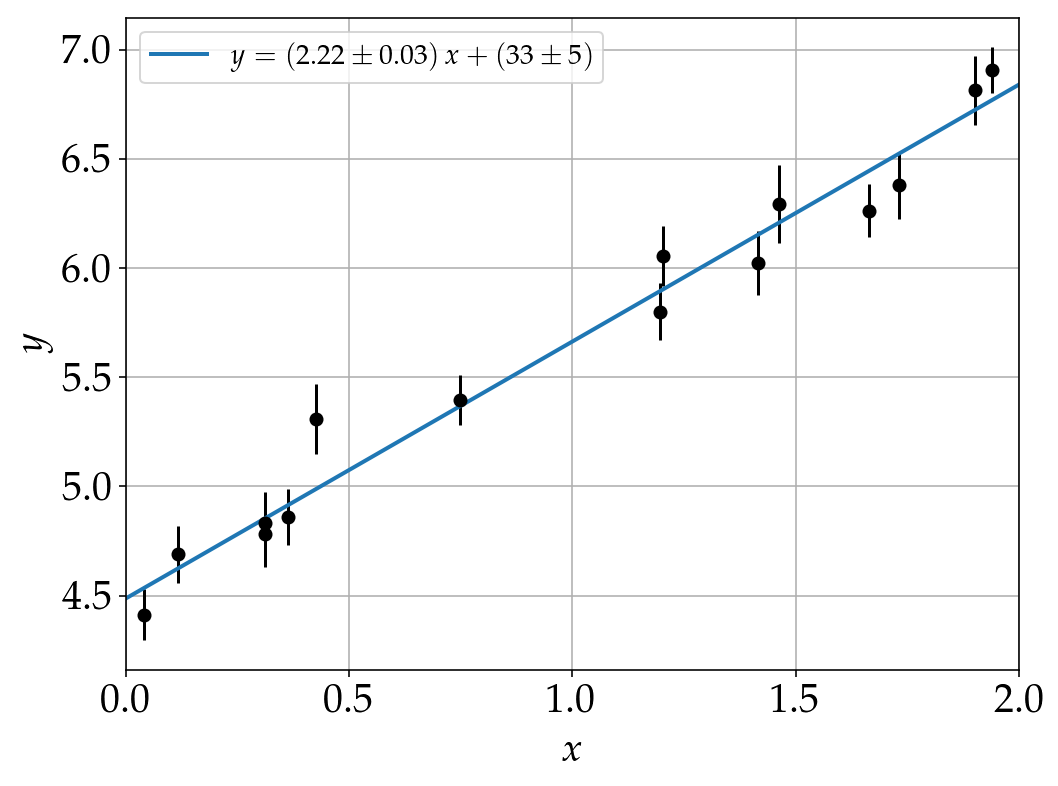

In [3]:
# Design matrix
Phi = np.column_stack((np.ones(len(x)), x))

Y = y[:, np.newaxis] # Transform array to column vector

# Covariance matrix
C = np.diag(y_err)
inv_C = np.linalg.inv(C)

sol = np.linalg.inv(Phi.T @ inv_C @ Phi) @ (Phi.T @ inv_C @ Y)
sol_variance = np.linalg.inv(Phi.T @ inv_C @ Phi)
print("w which minimizes the chi-squared: \n", sol)
print("Covariance matrix for the parameters: \n", np.sqrt(sol_variance))

# Plot data and best fit line
fig, ax = plt.subplots(figsize=(8, 6))

x_ = np.linspace(0, 2., 100)

ax.errorbar(x, y, y_err, fmt='o', color='black')
ax.grid(True)
ax.plot(x_, sol[1]*x_ + sol[0], 'C0', label=r'$y=(2.22\pm 0.03)\,x+(33\pm 5)$', lw=2)
ax.legend(prop={'size': 14})
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim(0, 2.)

The above procedure can be trivialy extended to any model of the data which is *linear in the parameters*, all
we have to do is to expand the design matrix. For example, if we wanted to fit a second degree polynomial, we'd have

$$
\boldsymbol \Phi=
\begin{bmatrix}
    1 &  x_1 & x_1^2\\
    1 & x_2 & x_2^2\\
    \vdots & \vdots & \vdots\\
    1 & x_N & x_N^2
\end{bmatrix}
$$

In general, we can construct $\mathbf{\Phi}$ with dimension $(N, D)$, such that each row is an arbitrary vector 
valued function of $\mathbf{x}$:


$$\mathbf{\Phi}=
\begin{bmatrix}
\boldsymbol{\phi}(\mathbf{x}^{(1)})\\
\vdots\\
\boldsymbol{\phi}(\mathbf{x}^{(N)})
\end{bmatrix}$$

where each $\phi_k$ ($k=1\dots D$) is called a *basis function*. The function $f(\mathbf{x})$ we fit to the data
in order to predict $\mathbf{y}$ is then is then given by a *linear*  combination of D basis functions, or in matrix
notation:

$$f(\mathbf{x})=\mathbf{\Phi}\mathbf{w}=\sum_{n=1}^Nw_n\phi_n(\mathbf{x})$$

The model $f(\mathbf{x})$ is called linear
regression because it is linear in the parameters, not the data. Linear models can be very powerfull and are widely used in statistics. It's easy to extend the code above to fit any combination of basis functions you like.

# Metropolis-Hastings MCMC


We now proceed to fit the same model with a simple Metropolis-Hastings Markov Chain Monte Carlo sampler. Instead of *optimizing* (taking derivatives to find a minimum, either analytic or numerical) a still fairly arbitrary $\chi^2$ function, we instead *sample* (calculating integrals, no derivatives needed) a 
*posterior probability distribution* of a model with a Gaussian *likelihood function* where the posterior is given by

$$p(m,b\lvert \mathbf y)\propto p(\mathbf{y}\lvert m,b)p(m,b)$$

The likelihood is given by

$$p(\mathbf{y}\lvert m,b)=\mathcal{L}=\prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(
    - \frac{\left[y_i-mx_i-b\right]^2}{2\sigma_i^2} \right)
$$

and for the prior, we assume that the slope and the intercept are independent and write

$$p(m,b)=p(m)p(b)$$

We choose the simplest option which is a  uniform prior for both in some range because the choice of 
priors doesn't matter much in this simpler problem.

$$m\sim U(0, 100)$$
$$b\sim U(-1000, 1000)$$

For a practical guide on choosing prior distributions for model parameters, see https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations .

In [4]:
def line_model(pars, x):
    m, b = pars
    return m*x + b

# The following code is from one of the Astro Hack Week workshops
class StraightLineModel(object):
    def __init__(self, x, y, y_err):
        """ 
        We store the data as attributes of the object so we don't have to 
        keep passing it in to the methods that compute the probabilities.
        """
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.y_err = np.asarray(y_err)

    def ln_likelihood(self, pars):
        """
        We don't need to pass in the data because we can access it from the
        attributes. This is basically the same as the weighted squared 
        deviation function, but includes the constant normalizations for the
        Gaussian likelihood.
        """
        N = len(self.y)
        dy = self.y - line_model(pars, self.x)
        ivar = 1 / self.y_err**2 # inverse-variance
        return -0.5 * (N*np.log(2*np.pi) + np.sum(2*np.log(self.y_err)) + np.sum(dy**2 * ivar))

    def ln_prior(self, pars):
        """ 
        The prior only depends on the parameters, so we don't need to touch
        the data at all. We're going to implement a flat (uniform) prior 
        over the ranges:
            m : [0, 100]
            b : [-1000, 1000]
        
        """
        
        m, b = pars # unpack parameters
        ln_prior_val = 0. # we'll add to this

        if m < 0 or m > 100.:
            return -np.inf
        else:
            return 0

        if b < -1000 or b > 1000.:
            return -np.inf
        else:
            return 0

        return ln_prior_val

    def ln_posterior(self, pars):
        """ 
        Up to a normalization constant, the log of the posterior pdf is just 
        the sum of the log likelihood plus the log prior.
        """
        lnp = self.ln_prior(pars)
        if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
            return lnp

        lnL = self.ln_likelihood(pars)
        lnprob = lnp + lnL

        if np.isnan(lnprob):
            return -np.inf

        return lnprob
    
    def __call__(self, pars):
        return self.ln_posterior(pars)

In [5]:
def sample_proposal(*sigmas):
    return np.random.normal(0., sigmas)

def run_metropolis_hastings(p0, n_steps, model, proposal_sigmas):
    """
    Run a Metropolis-Hastings MCMC sampler to generate samples from the input
    log-posterior function, starting from some initial parameter vector.
    
    Parameters
    ----------
    p0 : iterable
        Initial parameter vector.
    n_steps : int
        Number of steps to run the sampler for.
    model : StraightLineModel instance (or subclass)
        A callable object that takes a parameter vector and computes 
        the log of the posterior pdf.
    proposal_sigmas : list, array
        A list of standard-deviations passed to the sample_proposal 
        function. These are like step sizes in each of the parameters.
    """
    p0 = np.array(p0)
    if len(proposal_sigmas) != len(p0):
        raise ValueError("Proposal distribution should have same shape as parameter vector.")
    
    # the objects we'll fill and return:
    chain = np.zeros((n_steps, len(p0))) # parameter values at each step
    ln_probs = np.zeros(n_steps) # log-probability values at each step
    
    # we'll keep track of how many steps we accept to compute the acceptance fraction                        
    n_accept = 0 
    
    # evaluate the log-posterior at the initial position and store starting position in chain
    ln_probs[0] = model(p0)
    chain[0] = p0
    
    # loop through the number of steps requested and run MCMC
    for i in range(1,n_steps):
        # proposed new parameters
        step = sample_proposal(*proposal_sigmas)
        new_p = chain[i-1] + step
        
        # compute log-posterior at new parameter values
        new_ln_prob = model(new_p)
        
        # log of the ratio of the new log-posterior to the previous log-posterior value
        ln_prob_ratio = new_ln_prob - ln_probs[i-1]
        
        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform())):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1
            
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
    
    acc_frac = n_accept / n_steps
    return chain, ln_probs, acc_frac

For our MH MCMC algorithm, we have to specify the initial values of the parameters and the standard deviations of the Gaussian proposal distributions. These standard deviations define a characteristic step size
in the parameter space. If they're too large we migght never jump to regions of high probability and our
acceptance fraction will be low, if they're too small almost all of the steps will be accepted but we might
not explore the parameter space well enough. Trying playing with the values and see what happens.

In [6]:
model = StraightLineModel(x, y, y_err)
initial_params = [0., 0.]
proposal_sigmas = [0.05, 0.05]

# Run MCMC with 1000 steps
chain, ln_probs, acc_frac = run_metropolis_hastings(initial_params, 10000, model, proposal_sigmas)

Shape of chain: 
 (10000, 2)
Acceptance fraction: 
 0.4263


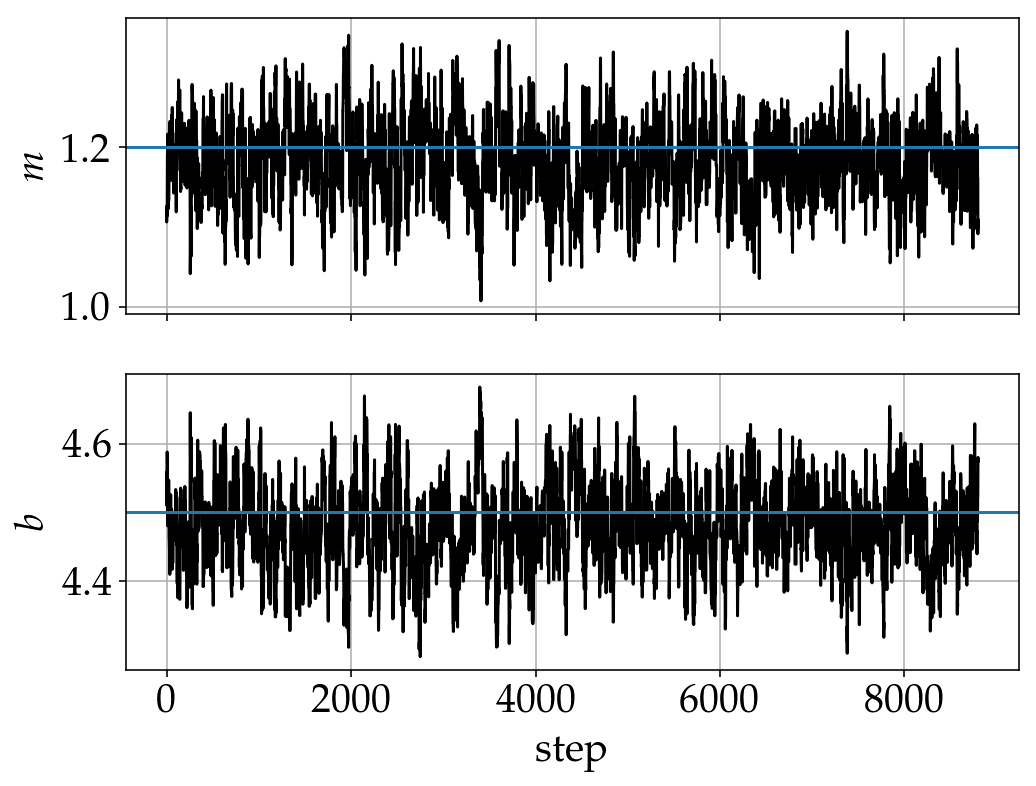

In [7]:
print("Shape of chain: \n", np.shape(chain))
print("Acceptance fraction: \n", np.mean(acc_frac))

fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)

for a in ax.ravel():
    a.grid(True)
ax[0].plot(chain[1200:, 0], 'k-')
ax[0].axhline(m_true)
ax[0].set_ylabel(r'$m$')
ax[1].plot(chain[1200:, 1], 'k-')
ax[1].axhline(b_true)
ax[1].set_ylabel(r'$b$')
ax[1].set_xlabel(r'step')

The trace plots look great, no further diagnostics are needed in this case. Let's not plot the model in the data space, instead of plotting just one line (with say the median or the mean parameters of all the samples), 
it's more useful to plot all of the lines between the 16th and the 84th percentile of parameter samples which corresponds to a width of one sigma for a Gaussian distribution.


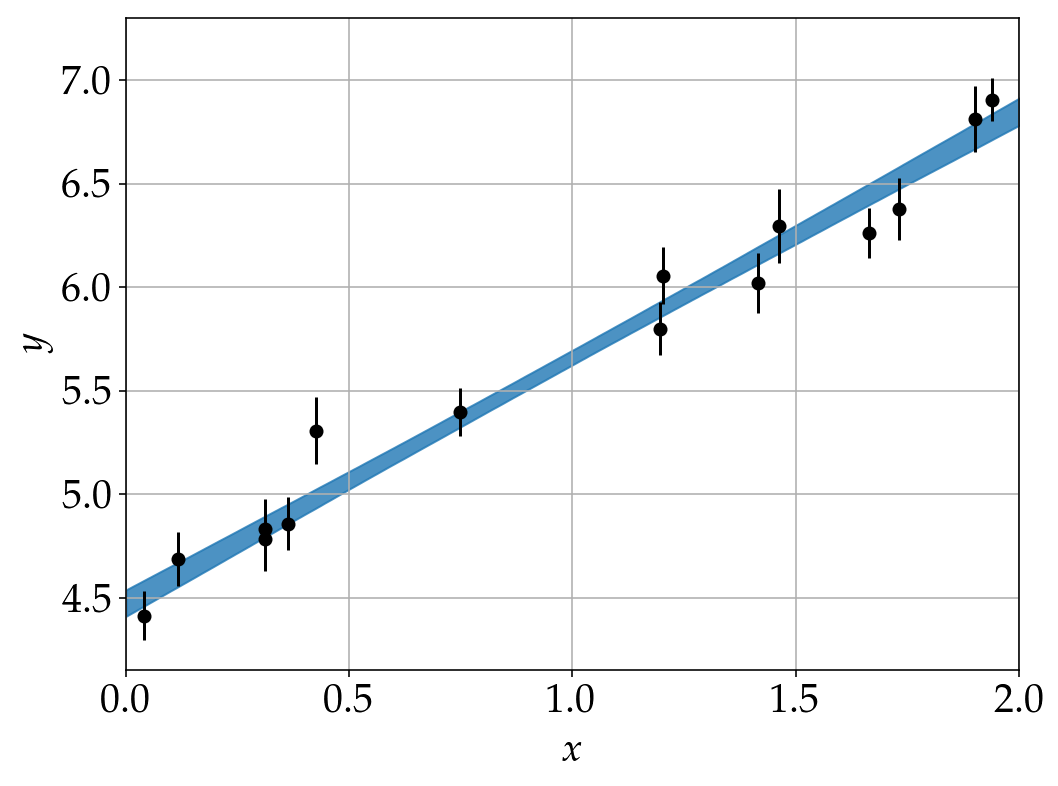

In [8]:
# Plot data
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(x, y, y_err, fmt='o', color='black')
ax.grid(True)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim(0, 2.)

x_dense = np.linspace(0, 2.2, 1000)

# Compute the quantiles of the predicted line and plot them.
A = np.vander(x_dense, 2)
lines = np.dot(chain, A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
ax.fill_between(x_dense, quantiles[0], quantiles[1], color="C0", alpha=0.8)

Finally, we plot 2 dimensional projections of the sampled parameters using in a "triangle plot". Since our
parameter space is 2 dimensional there's only one projection. To plot this you need the `corner` Python package developed by Daniel Foreman Mackey. Use `pip install corner`.

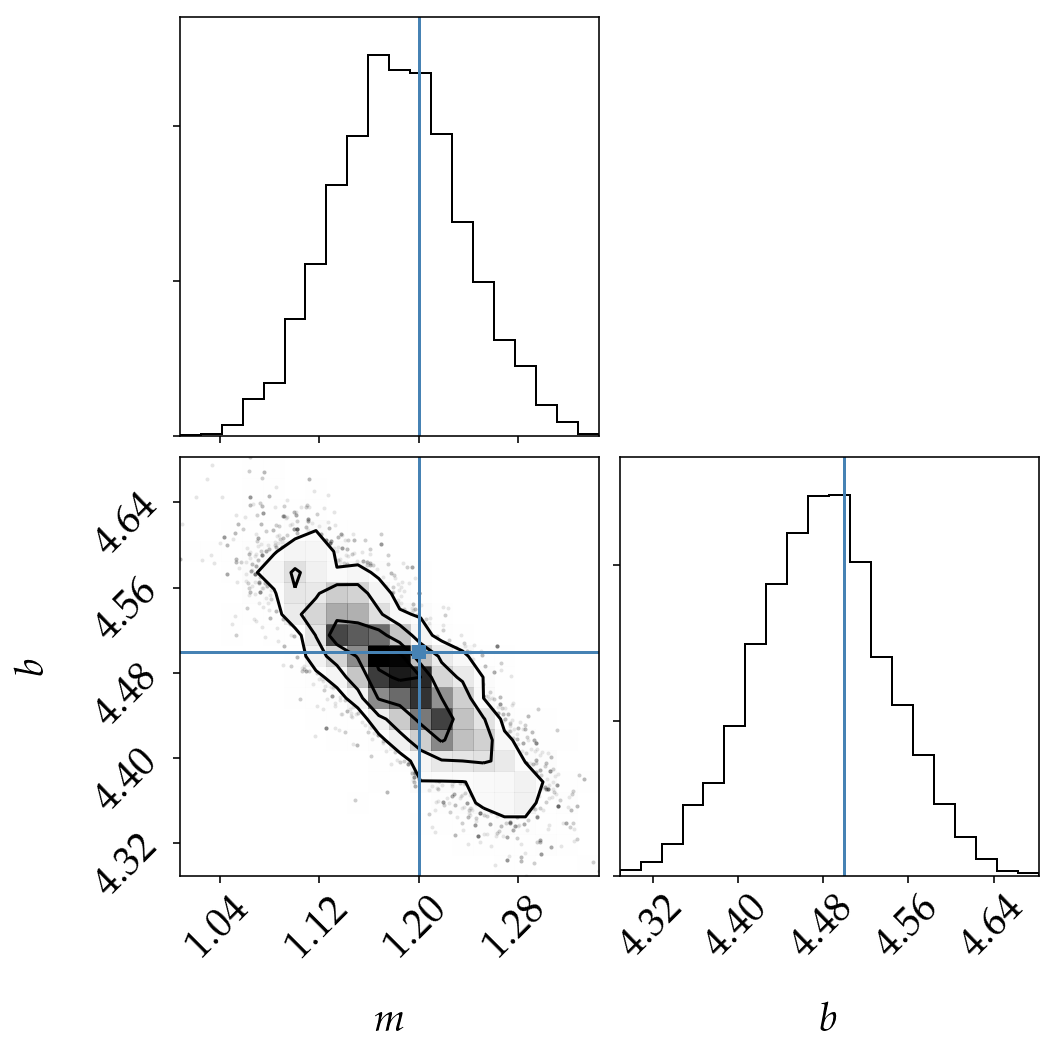

In [9]:
import corner

labels = [r'$m$', r'$b$']
fig = corner.corner(chain[500:], labels=labels, truths=[m_true, b_true])
fig.set_size_inches(8, 8)

# Extending the  model

There are many ways to extend this model. For example, we might have some outliers in our data, points which
aren't consistent with Gaussian noise around the mean model. In that case one thing we could do is to model
the points with a mixture of two Gaussians, one which describes the line model and the other which describes an
outlier model. Each data point then has a certain probability of being drawn from either the line model or the 
outlier model and this probability can be inferred. Daniel Foreman Mackey has an excellent blog post about that
including the code, check it out here: http://dfm.io/posts/mixture-models/.


Finally, we might have uncertanties in the $x$ direction as well with arbitrary covariances between the data
points, we could also have intrinsic scatter in the data. How to fit a line in that case is covered in another
excellent blog post by Foreman-Mackey: http://dfm.io/posts/fitting-a-plane/.

# Fitting the model with emcee

So far we've only tried the simplest MCMC sampler, Metropolis-Hastings. This might not cut it for more complex models with highly covariant parameters. One other sampler which is very popular in astrophysics is `emcee`.
It is a Python code implementing an affine invariant ensamble sampler described in this paper: http://adsabs.harvard.edu/abs/2010CAMCS...5...65G.

Instead of using just one chain, emcee uses several chains (called walkers) and pools the information accross the different chains in order to automatically choose a proposal distribution at each step.

You can install emcee with `pip install emcee`.

In [10]:
import emcee
print(emcee.__version__)

2.2.1


In [11]:
ndim = 2
nwalkers = 30
nsteps = 2000

# Generate initial parameters for all of the walkers
initial_params_emcee = np.zeros((nwalkers, 2))    
initial_params_emcee[:, 0] = np.random.normal(0, 1., nwalkers) # m
initial_params_emcee[:, 1] = np.random.normal(0, 1., nwalkers) # b

sampler = emcee.EnsembleSampler(nwalkers, ndim, model.ln_posterior)
sampler.run_mcmc(initial_params_emcee, nsteps);

/home/fran/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/fran/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [12]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.704


(30, 2000, 2)


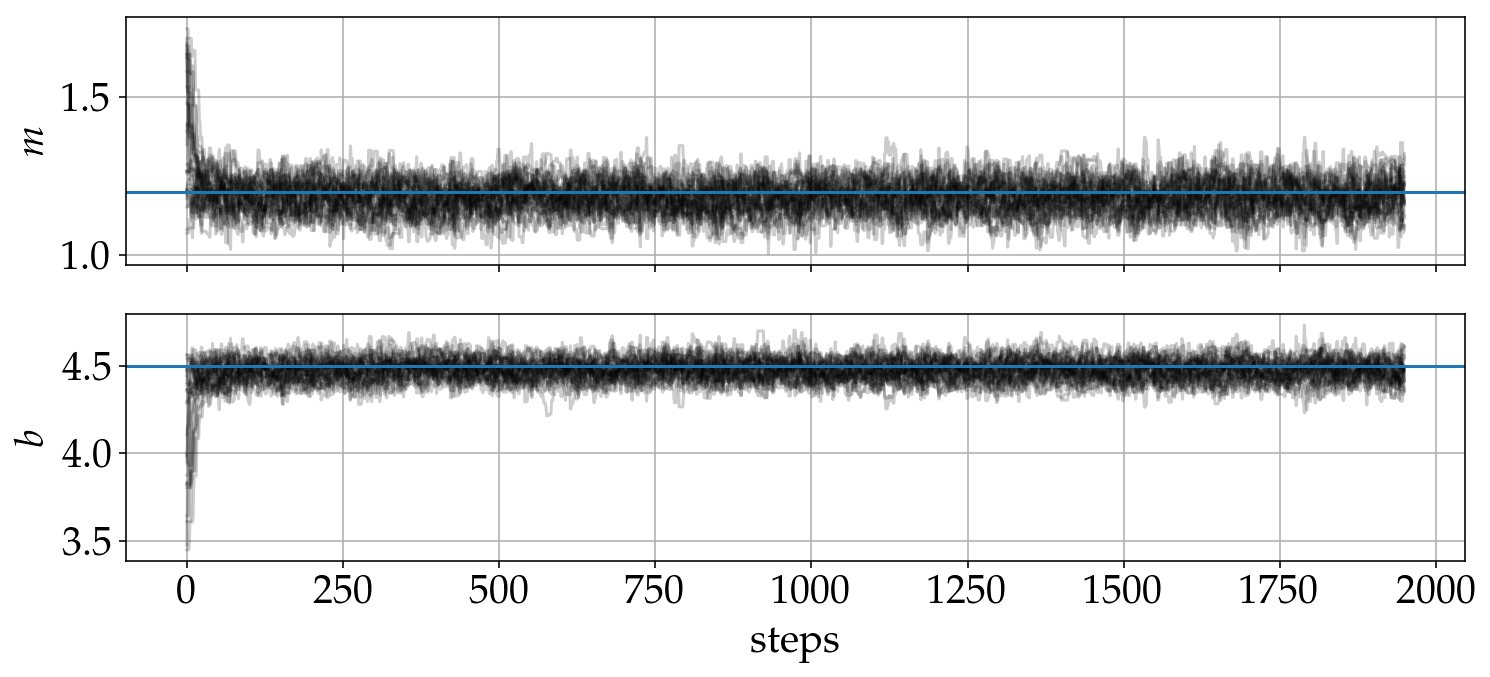

In [13]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12,5))

print(np.shape(sampler.chain))

for a in ax.ravel():
    a.grid(True)

ax[0].plot(sampler.chain[:, 50:, 0].T, 'k-', alpha=0.2);
ax[0].set_ylabel(r'$m$')
ax[0].axhline(m_true)
ax[1].plot(sampler.chain[:, 50:, 1].T, 'k-', alpha=0.2);
ax[1].set_ylabel(r'$b$')
ax[1].set_xlabel(r'steps')
ax[1].axhline(b_true)

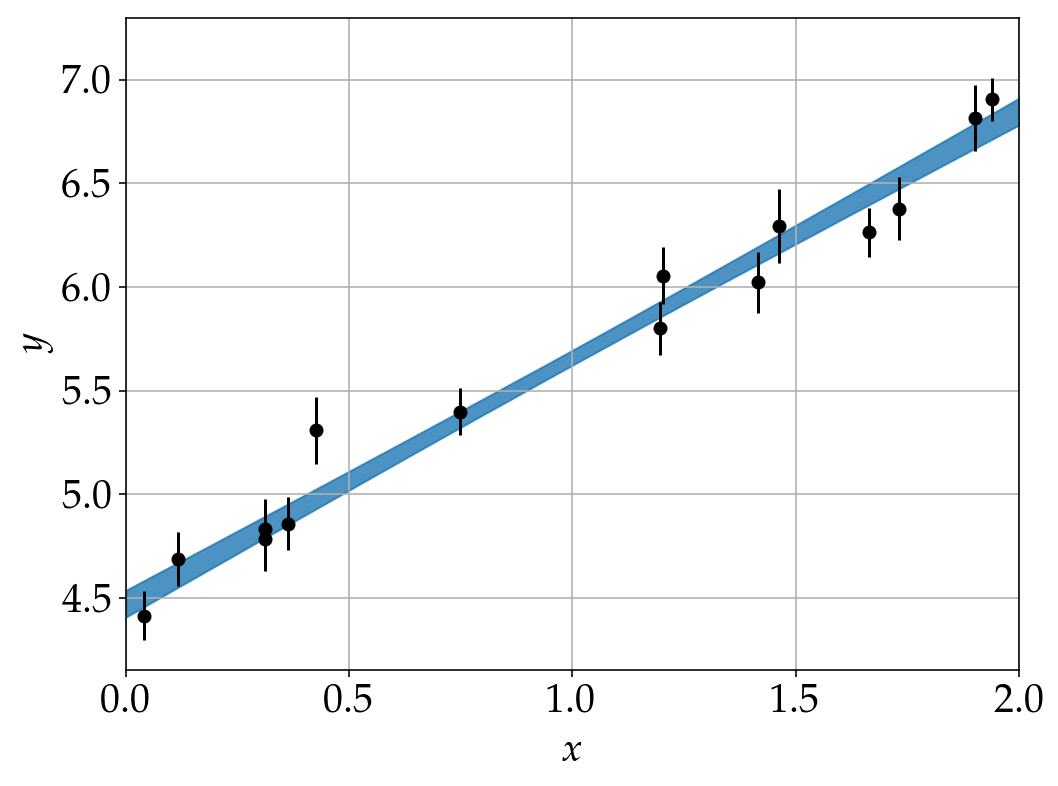

In [14]:
# Plot data
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(x, y, y_err, fmt='o', color='black')
ax.grid(True)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim(0, 2.)

# Compute the quantiles of the predicted line and plot them.
A = np.vander(x_dense, 2)
lines = np.dot(sampler.flatchain[::5], A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
ax.fill_between(x_dense, quantiles[0], quantiles[1], color="C0", alpha=0.8)

(30, 2000, 2)


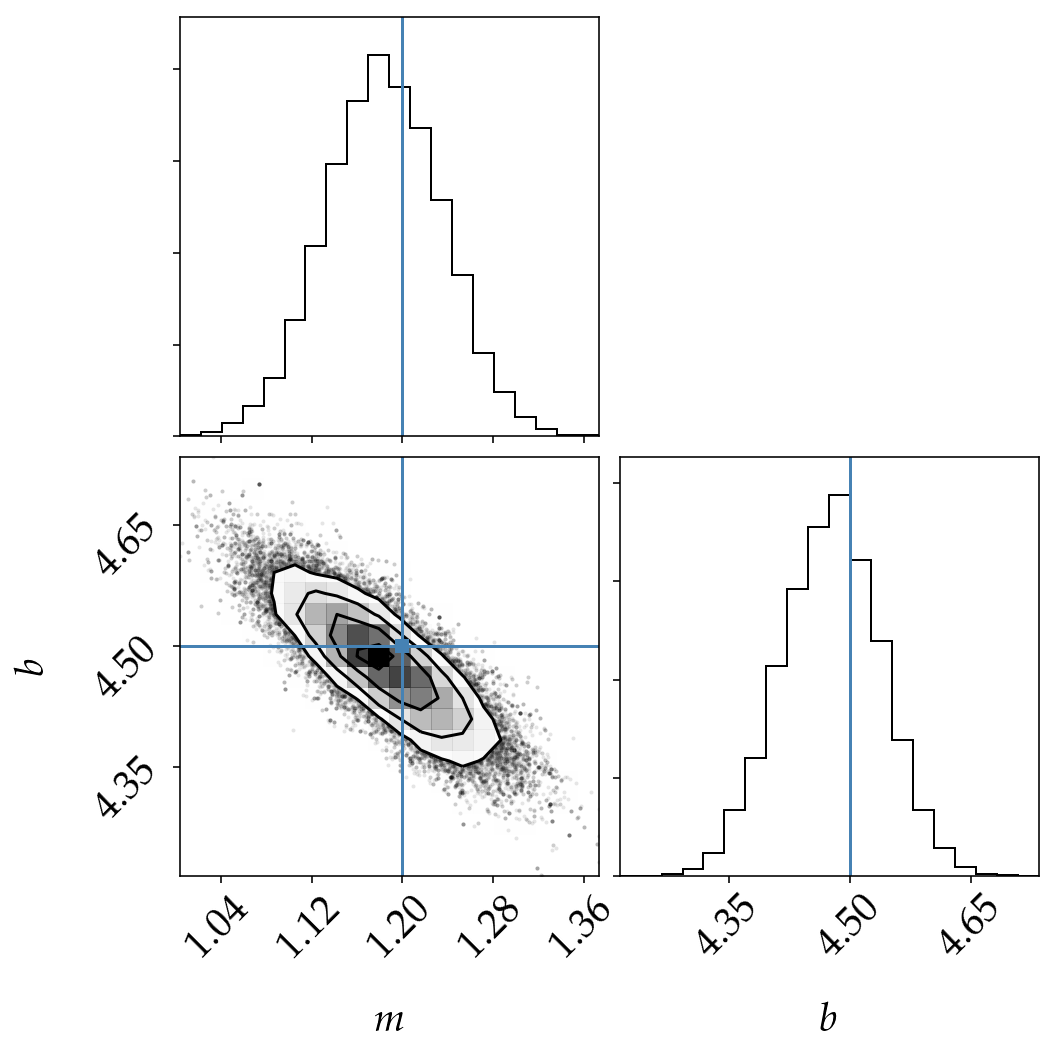

In [15]:
labels = [r'$m$', r'$b$']

print(np.shape(sampler.chain))

samples = sampler.chain[:, 100:, :].reshape(-1, 2)

fig = corner.corner(samples, labels=labels, truths=[m_true, b_true])
fig.set_size_inches(8, 8)

# Useful resources

Beautiful introduction to probability theory from one of the developers of Stan:
https://betanalpha.github.io/assets/case_studies/probability_theory.html#54_sampling_from_conditional_distributions 

An interactive visualization of the various MCMC samplers, this is super useful for understanding how the different samplers work:
https://chi-feng.github.io/mcmc-demo/app.html#RandomWalkMH,standard

A series of blog posts/Jupyter notebooks on the differences between Frequentist and Bayesian statistics by an astronomer/Python developer Jake VanderPlas. The discussion in the comments is also really interesting:
http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/

A short blog post on Hamiltonian Monte Carlo:
http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/

A lengthy paper on using MCMC by David Hogg and Dan Foreman Mackey:
https://arxiv.org/abs/1710.06068

A Jupyter notebook comparing 9 different samplers including 5 Nested Sampling samplers:
http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/